# Аналіз цін на житло в Каліфорнії

У цьому ноутбуці ми проведемо аналіз набору даних California Housing та побудуємо моделі для прогнозування цін на житло.

# [Домашнє завдання до модуля «Алгоритми навчання з вчителем Ч.1»](https://www.edu.goit.global/uk/learn/25315460/23598278/23988991/homework)
___

## 1. Імпортуємо необхідні бібліотеки

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

warnings.filterwarnings("ignore")

# Налаштування стилю
plt.style.use('seaborn-v0_8')
sns.set_theme(style="whitegrid")

## 2. Завантаження та підготовка даних

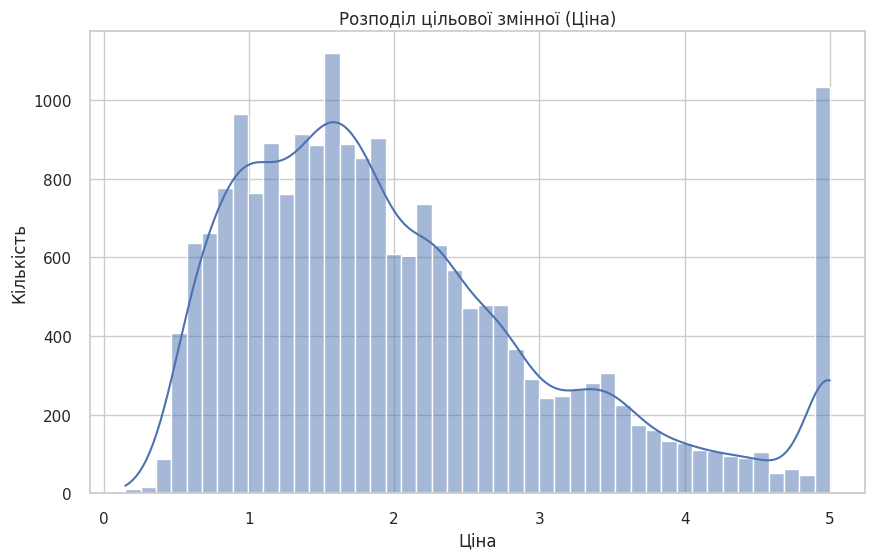

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [15]:
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df["PRICE"] = california.target

# Візуалізація початкового розподілу цільової змінної
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="PRICE", kde=True)
plt.title("Розподіл цільової змінної (Ціна)")
plt.xlabel("Ціна")
plt.ylabel("Кількість")
plt.show()

df

## 3. Аналіз даних (EDA)

Missing Values:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
PRICE         0
dtype: int64


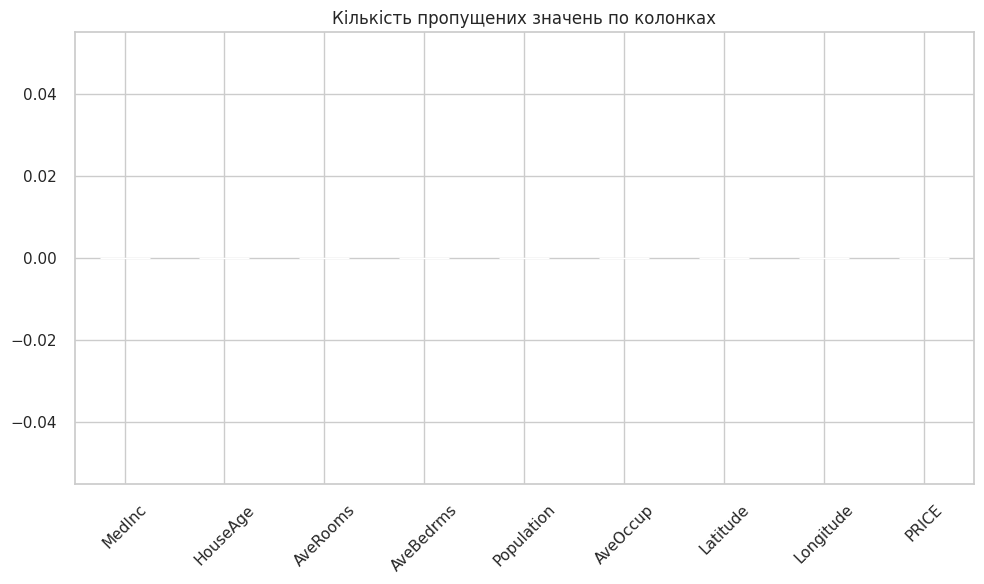

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   PRICE       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
Statistical Summary:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


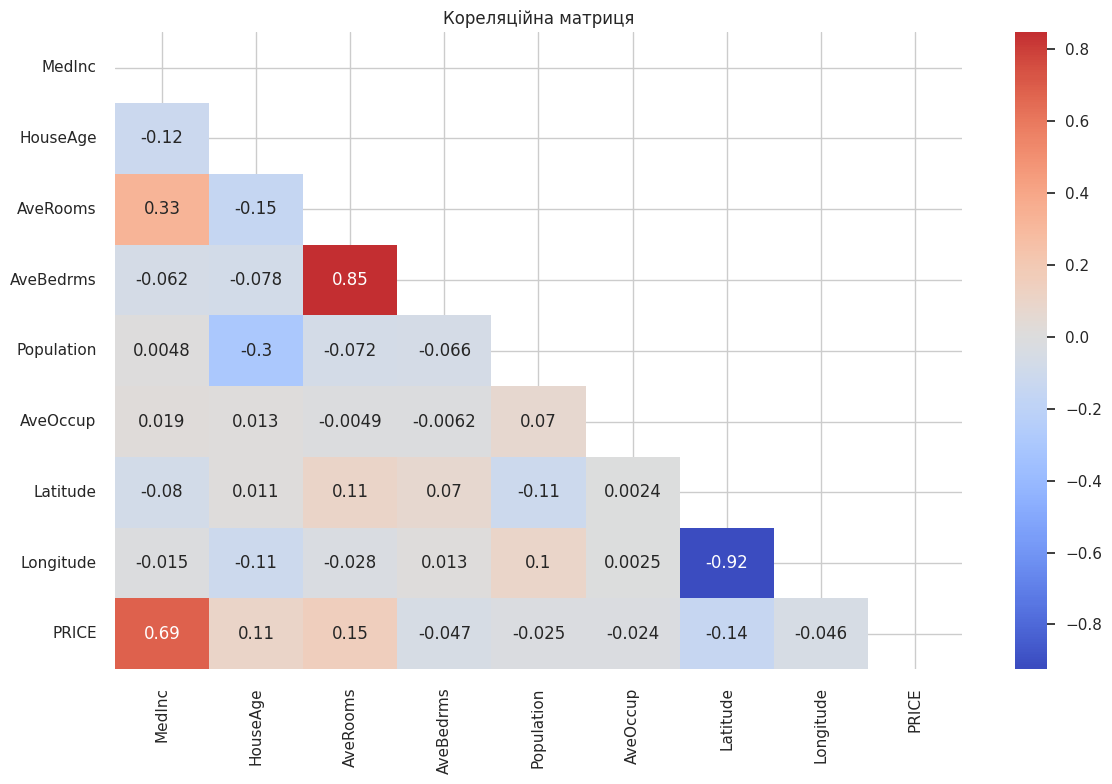

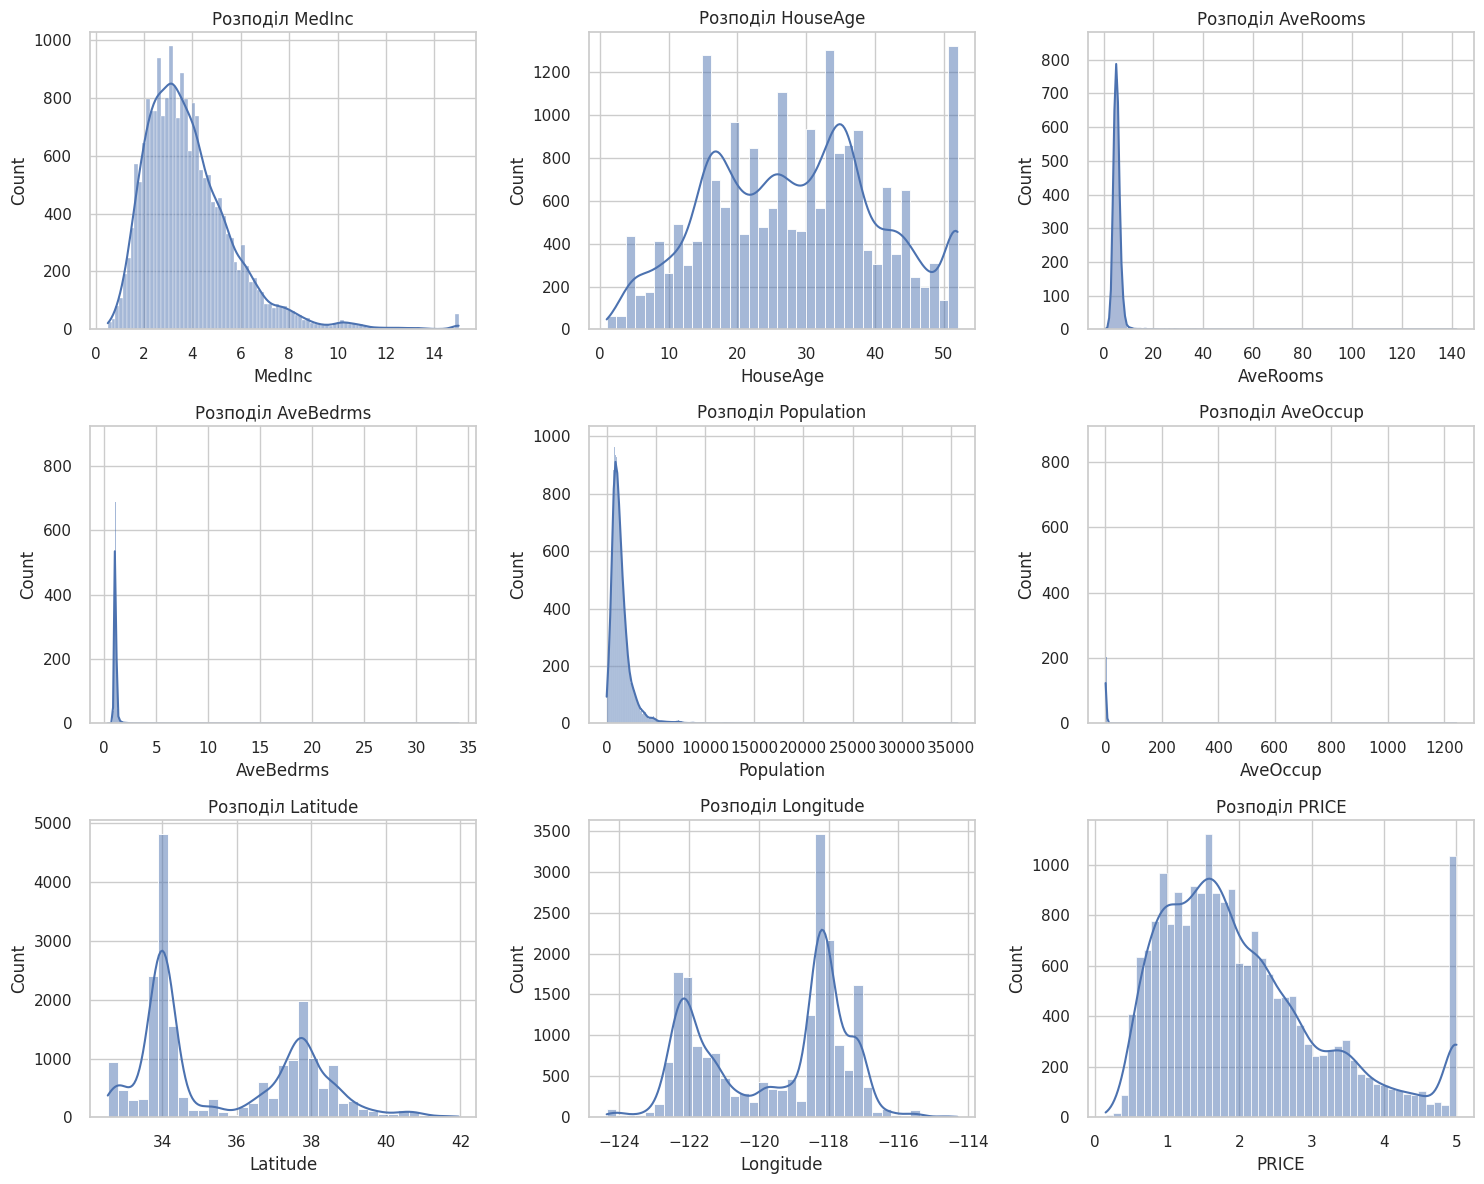

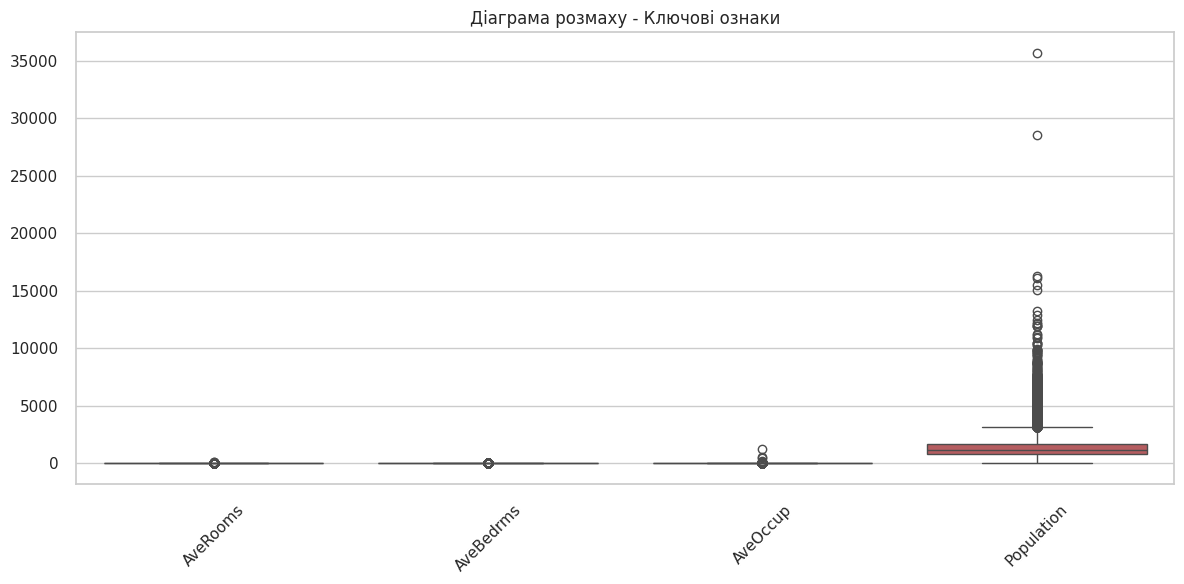

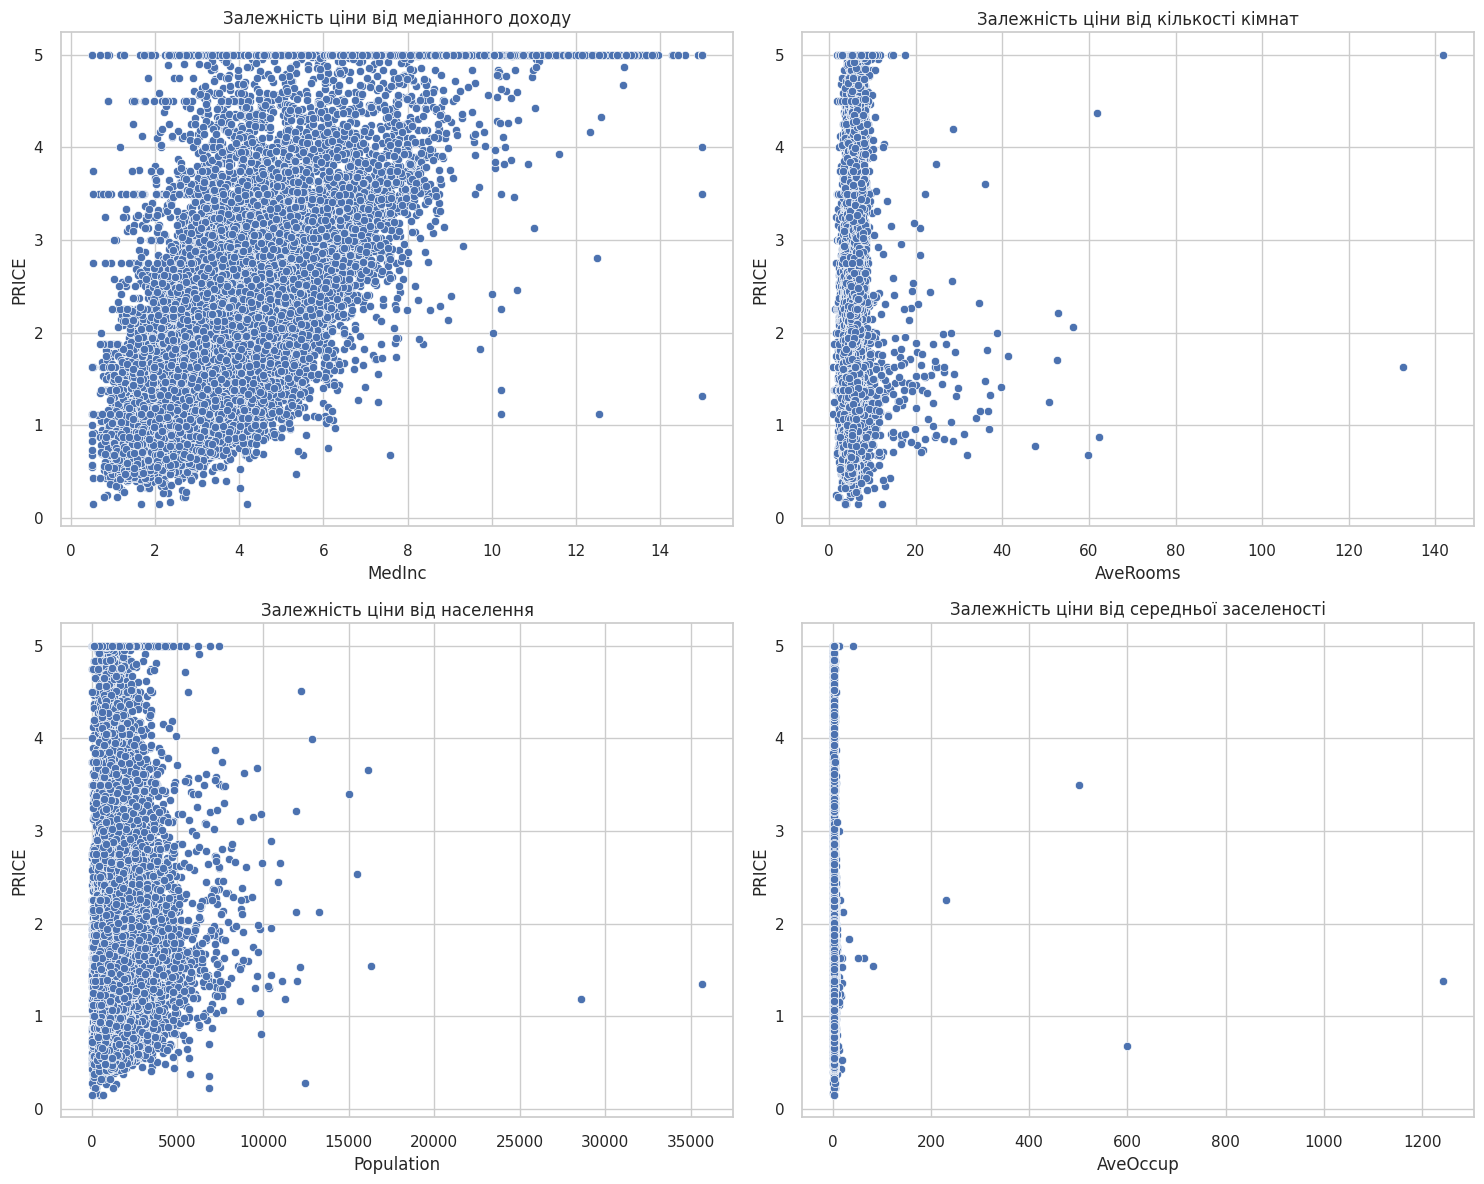

In [3]:
print("Missing Values:")
missing_values = df.isnull().sum()
print(missing_values)

# Візуалізація пропущених значень
plt.figure(figsize=(10, 6))
missing_values.plot(kind="bar")
plt.title("Кількість пропущених значень по колонках")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Basic Info:")
print(df.info())
print("Statistical Summary:")
display(df.describe())

# Кореляційна матриця
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", center=0)
plt.title("Кореляційна матриця")
plt.tight_layout()
plt.show()

# Розподіл числових ознак
numeric_cols = df.columns
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], ax=axes[i], kde=True)
    axes[i].set_title(f"Розподіл {col}")
plt.tight_layout()
plt.show()

# Діаграма розмаху для виявлення викидів
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["AveRooms", "AveBedrms", "AveOccup", "Population"]])
plt.title("Діаграма розмаху - Ключові ознаки")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatter plots залежностей
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

sns.scatterplot(data=df, x="MedInc", y="PRICE", ax=axes[0])
axes[0].set_title("Залежність ціни від медіанного доходу")

sns.scatterplot(data=df, x="AveRooms", y="PRICE", ax=axes[1])
axes[1].set_title("Залежність ціни від кількості кімнат")

sns.scatterplot(data=df, x="Population", y="PRICE", ax=axes[2])
axes[2].set_title("Залежність ціни від населення")

sns.scatterplot(data=df, x="AveOccup", y="PRICE", ax=axes[3])
axes[3].set_title("Залежність ціни від середньої заселеності")

plt.tight_layout()
plt.show()

## 4. Очищення даних


Розмір до видалення викидів: (20640, 9)
Розмір після видалення викидів: (20135, 9)


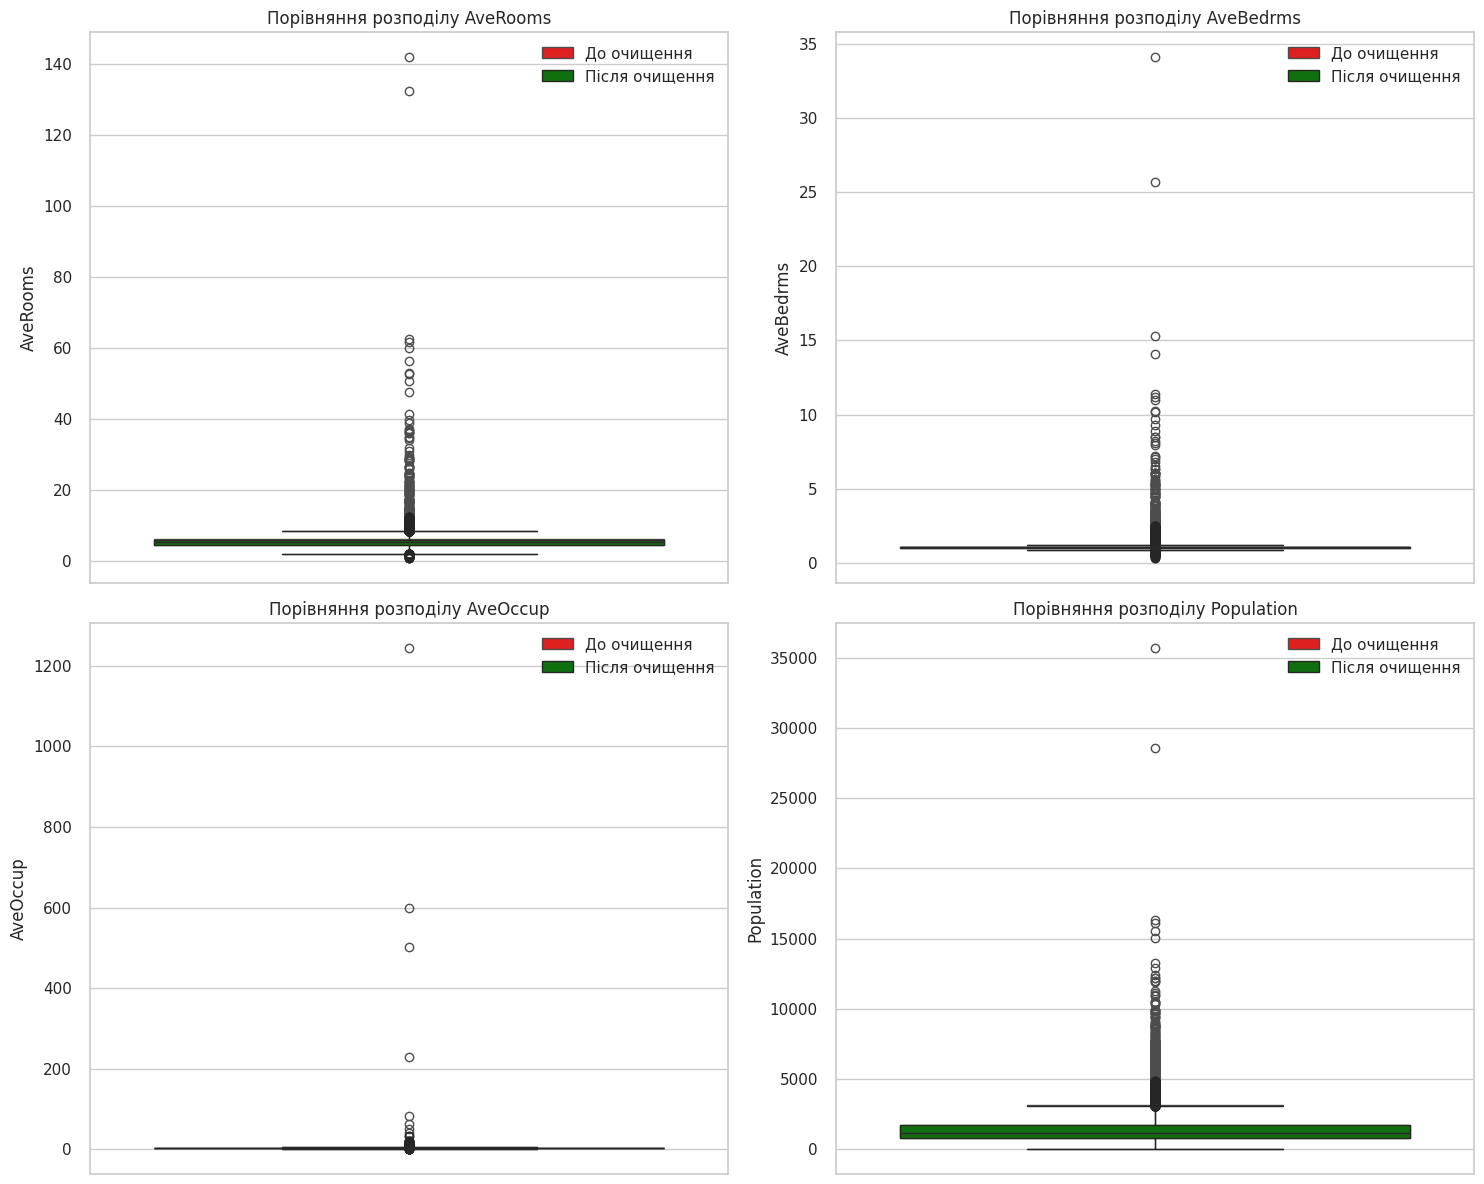

In [4]:
def detect_outliers(x):
    return np.abs(stats.zscore(x)) > 3.0

columns_to_clean = ["AveRooms", "AveBedrms", "AveOccup", "Population"]
outliers = df[columns_to_clean].apply(detect_outliers)
df_cleaned = df[~outliers.any(axis=1)]

print(f"\nРозмір до видалення викидів: {df.shape}")
print(f"Розмір після видалення викидів: {df_cleaned.shape}")

# Візуалізація результатів очищення
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(columns_to_clean):
    sns.boxplot(data=df[col], ax=axes[i], color="red", label="До очищення")
    sns.boxplot(
        data=df_cleaned[col], ax=axes[i], color="green", label="Після очищення"
    )
    axes[i].set_title(f"Порівняння розподілу {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

# Видалення 'AveBedrms' через високу кореляцію
df_cleaned = df_cleaned.drop("AveBedrms", axis=1)

## 5. Створення нових ознак

In [5]:
df_featured = df.copy()

# 1. Відношення кімнат до населення
df_featured["RoomsPerPerson"] = df_featured["AveRooms"] / df_featured["Population"]

# 2. Щільність населення
df_featured["PopulationDensity"] = df_featured["Population"] / df_featured["AveOccup"]

# 3. Логарифмуємо занчення для 'Population' та 'MedInc'
df_featured["LogPopulation"] = np.log1p(df_featured["Population"])
df_featured["LogIncome"] = np.log1p(df_featured["MedInc"])

# 4. Пробуємо кластеризувати за географічними ознаками
df_featured["LocationCluster"] = (df_featured["Latitude"] // 0.5) * 100 + (
    df_featured["Longitude"] // 0.5
)

# 5. Взаємодії між ознаками
df_featured["IncomePerRoom"] = df_featured["MedInc"] / df_featured["AveRooms"]
df_featured["RoomDensity"] = df_featured["AveRooms"] / df_featured["AveOccup"]

# 6. Відстань до океану
df_featured["OceanProximity"] = df_featured["HouseAge"] * (
    1 / (df_featured["Longitude"].abs() + 1)
)

# 7. Економічні індикатори
df_featured["WealthIndex"] = df_featured["MedInc"] * df_featured["AveRooms"] / df_featured["AveOccup"]

display(df_featured.head())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE,RoomsPerPerson,PopulationDensity,LogPopulation,LogIncome,LocationCluster,IncomePerRoom,RoomDensity,OceanProximity,WealthIndex
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,0.021690,126.0,5.777652,2.232720,7255.0,1.192017,2.732919,0.332711,22.752099
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,0.002598,1138.0,7.784057,2.230165,7255.0,1.330750,2.956685,0.170427,24.544622
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,0.016710,177.0,6.208590,2.111110,7255.0,0.875637,2.957661,0.421941,21.464931
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,0.010425,219.0,6.326149,1.893579,7255.0,0.970046,2.283154,0.421907,12.884067
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,0.011118,259.0,6.338594,1.578195,7255.0,0.612272,2.879646,0.421907,11.075695


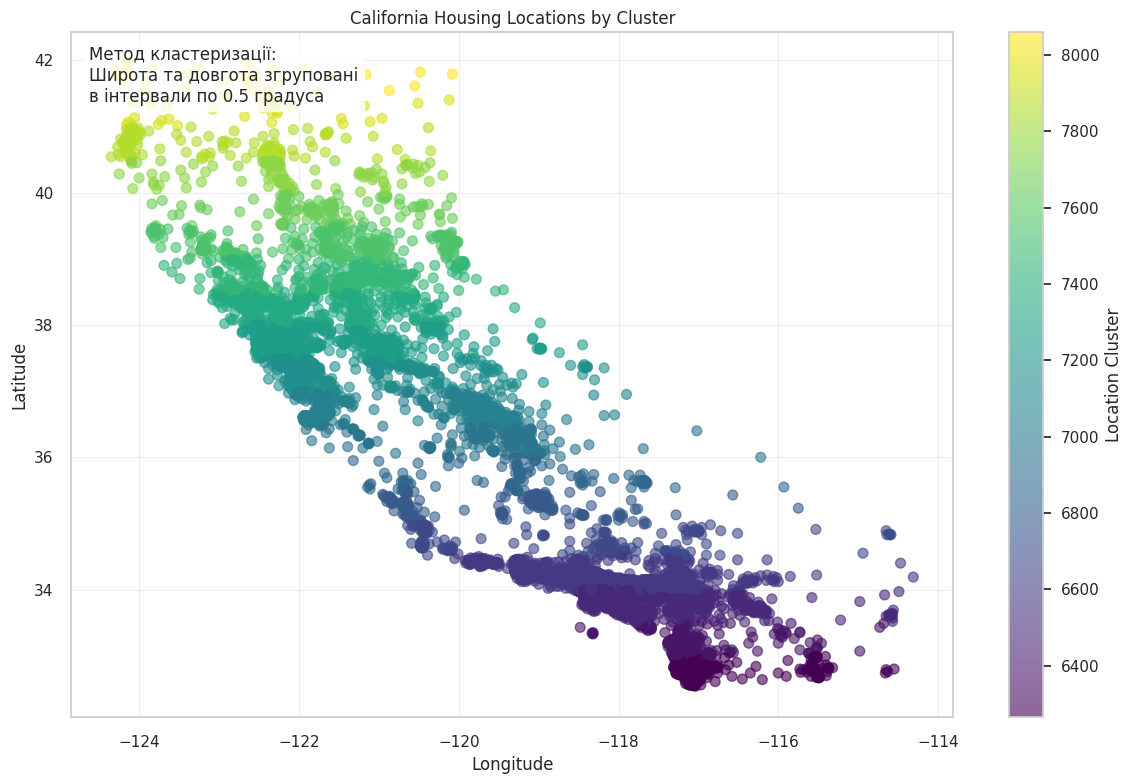

In [6]:
# Створення діаграми heatmap кластерів
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_featured["Longitude"], 
                     df_featured["Latitude"], 
                     c=df_featured["LocationCluster"], 
                     cmap='viridis', 
                     alpha=0.6,
                     s=50)

plt.colorbar(scatter, label='Location Cluster')
plt.title('California Housing Locations by Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

plt.text(0.02, 0.98, 
         'Метод кластеризації:\nШирота та довгота згруповані\nв інтервали по 0.5 градуса', 
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

In [7]:
# Видалення ознак
# df_featured = df_featured.drop(["Latitude", "Longitude", "HouseAge"], axis=1)

## 6. Підготовка даних для моделювання

In [8]:
def perform_feature_engineering(X_train, X_test):
    # Вибір колонок для поліноміальних ознак
    poly_features = ["MedInc", "AveRooms", "Population"]
    other_features = [col for col in X_train.columns if col not in poly_features]

    # Створення поліноміальних ознак
    poly = PolynomialFeatures(degree=2, include_bias=False)

    # Застосування поліноміальних перетворень до вибраних ознак
    X_train_poly = poly.fit_transform(X_train[poly_features])
    X_test_poly = poly.transform(X_test[poly_features])

    # Отримання імен поліноміальних ознак
    poly_feature_names = poly.get_feature_names_out(poly_features)

    # Створення DataFrame з поліноміальними ознаками
    X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names)
    X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_feature_names)

    # Додавання інших ознак
    X_train_transformed = pd.concat([X_train_poly_df, X_train[other_features]], axis=1)
    X_test_transformed = pd.concat([X_test_poly_df, X_test[other_features]], axis=1)

    # Формування списку всіх імен ознак
    feature_names = list(X_train_transformed.columns)

    return X_train_transformed, X_test_transformed, feature_names

In [9]:
# Розділення на тренувальну та тестову вибірки
X = df_featured.drop("PRICE", axis=1)
y = df_featured["PRICE"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature engineering
X_train_transformed, X_test_transformed, feature_names = perform_feature_engineering(X_train, X_test)

# Стандартизація ознак
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

# Перетворення назад у DataFrame для збереження назв колонок
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

## 7. Побудова та оцінка моделей

In [10]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    r_sq = model.score(X_train, y_train)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"\n{model_name} на тестовому наборі:")
    print(f"R2: {r_sq:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f} | RMSE: {rmse:.2f}")

    # Візуалізація прогнозів
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
    plt.xlabel("Реальні значення")
    plt.ylabel("Прогнозовані значення")
    plt.title(f"Порівняння прогнозів та реальних значень\n{model_name}")
    plt.tight_layout()
    plt.show()

    # Візуалізація різниці між прогнозами та реальними значеннями
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="--")
    plt.xlabel("Прогнозовані значення")
    plt.ylabel("Різниця")
    plt.title(f"Графік різниці\n{model_name}")
    plt.tight_layout()
    plt.show()

    # Q-Q графік
    plt.figure(figsize=(10, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"Q-Q графік різниці\n{model_name}")
    plt.tight_layout()
    plt.show()

    metrics = {"r2": r_sq, "mae": mae, "mape": mape, "rmse": rmse}
    return y_pred, residuals, metrics

In [11]:
def plot_feature_importance(model, feature_names, model_name=""):
    importance = np.abs(model.coef_)
    features_df = pd.DataFrame({"Feature": feature_names, "Importance": importance})
    features_df = features_df.sort_values("Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=features_df, x="Importance", y="Feature")
    plt.title(f"Важливість ознак\n{model_name}")
    plt.tight_layout()
    plt.show()

    return features_df


Лінійна регресія:

Лінійна регресія на тестовому наборі:
R2: 0.63 | MAE: 0.49 | MAPE: 0.40 | RMSE: 0.68


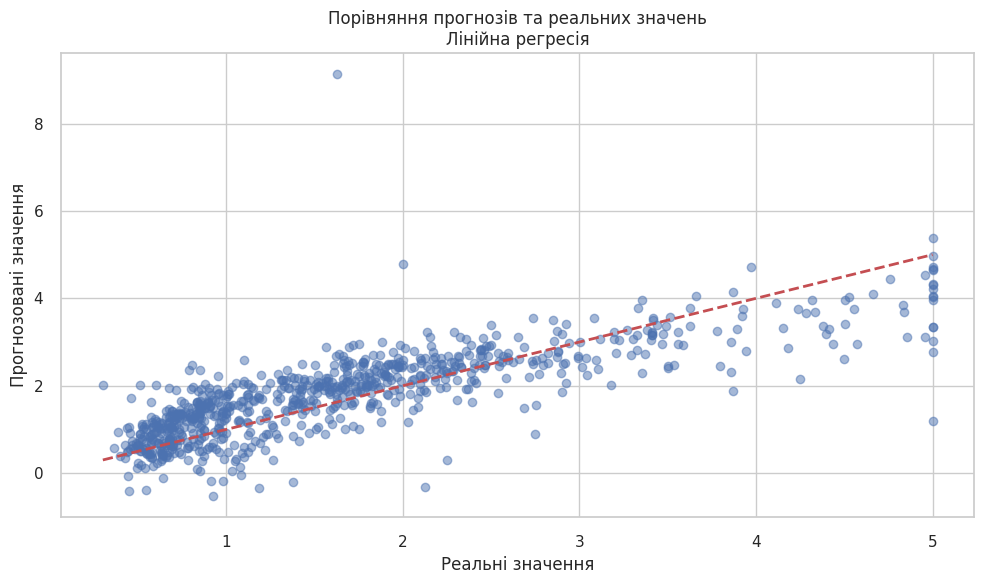

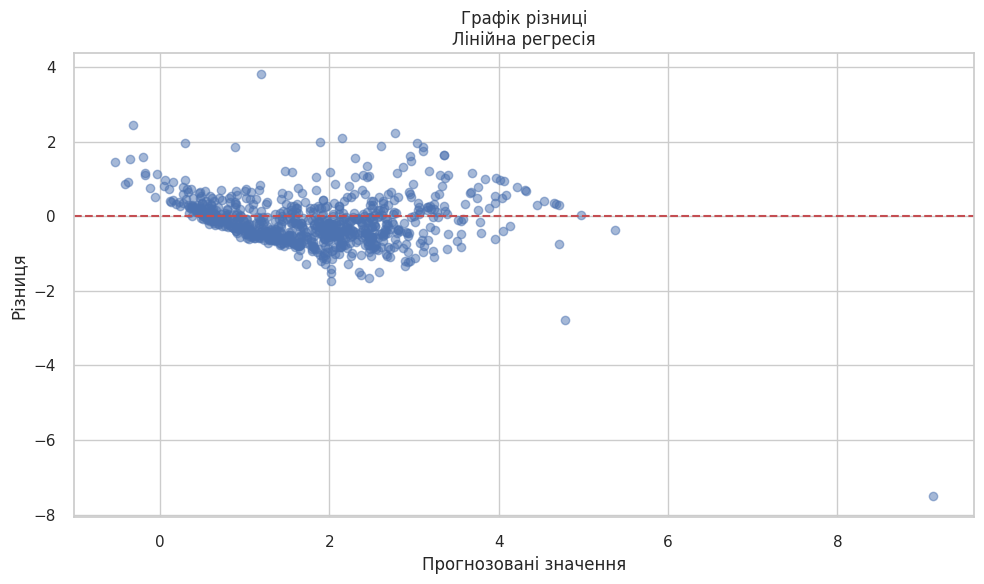

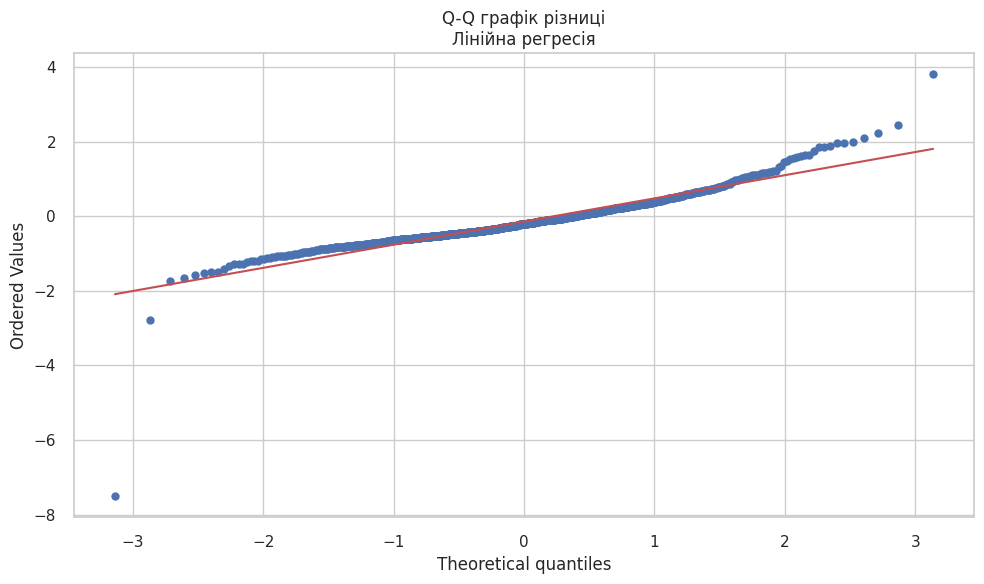

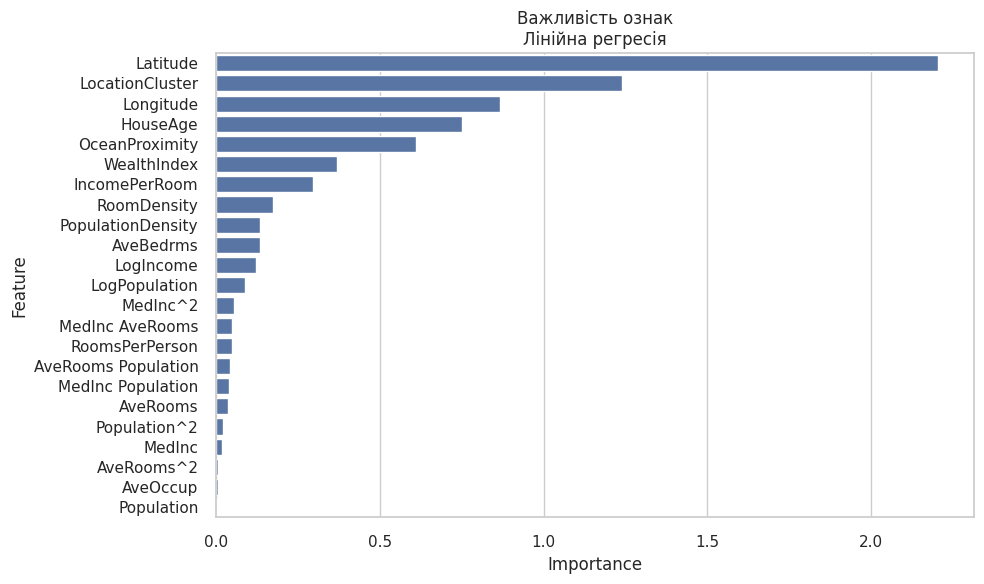

In [12]:
X_train_clean = X_train_scaled.dropna()
y_train_clean = y_train[X_train_clean.index]

X_test_clean = X_test_scaled.dropna()
y_test_clean = y_test[X_test_clean.index]

# Лінійна регресія
lr_model = LinearRegression()
lr_model.fit(X_train_clean, y_train_clean)

print("\nЛінійна регресія:")
y_pred_lr, residuals_lr, lr_metrics = evaluate_model(
    lr_model, X_train_clean, X_test_clean, 
    y_train_clean, y_test_clean, "Лінійна регресія"
)

# Візуалізація важливості ознак для лінійної регресії
lr_importance = plot_feature_importance(lr_model, X_train_clean.columns, "Лінійна регресія")


Найкращі параметри Ridge: {'alpha': 10.0}
Найкращий показник Ridge: 0.5217014193573539

Ridge регресія на тестовому наборі:
R2: 0.63 | MAE: 0.49 | MAPE: 0.40 | RMSE: 0.68


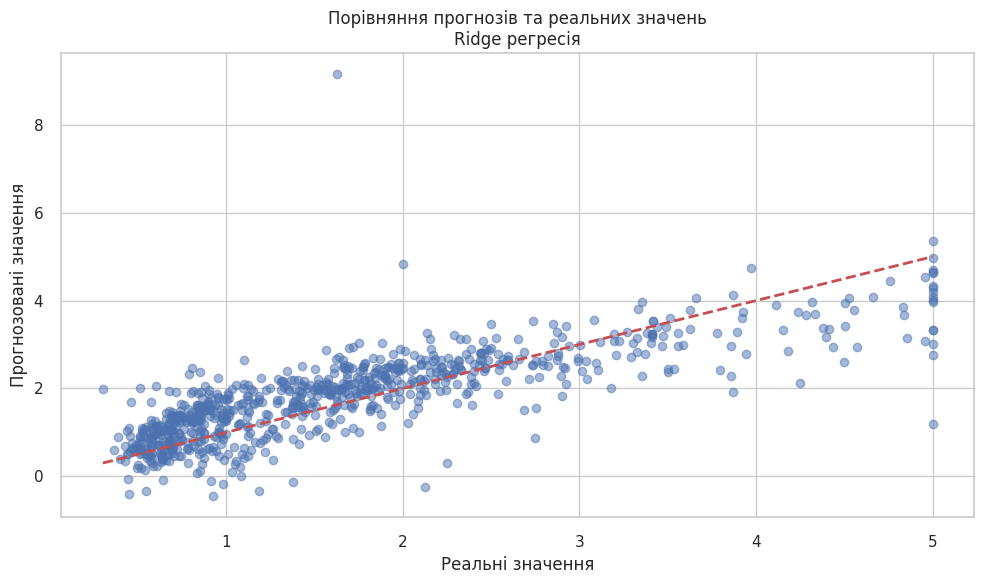

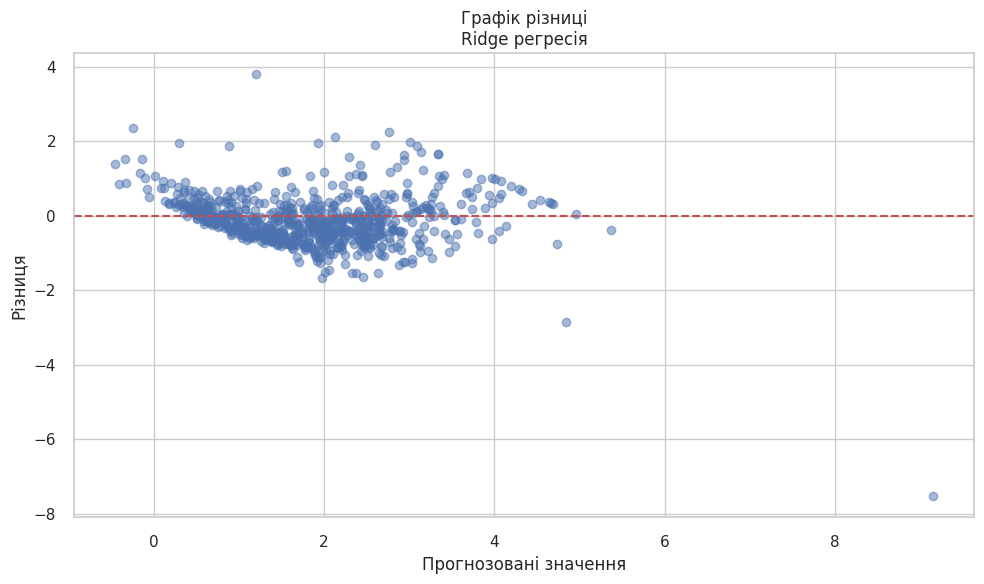

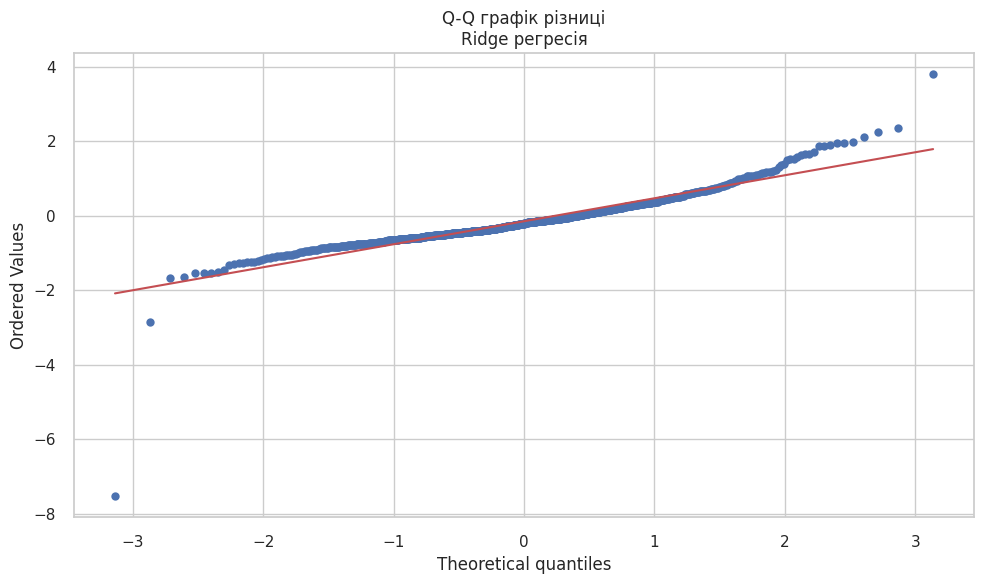

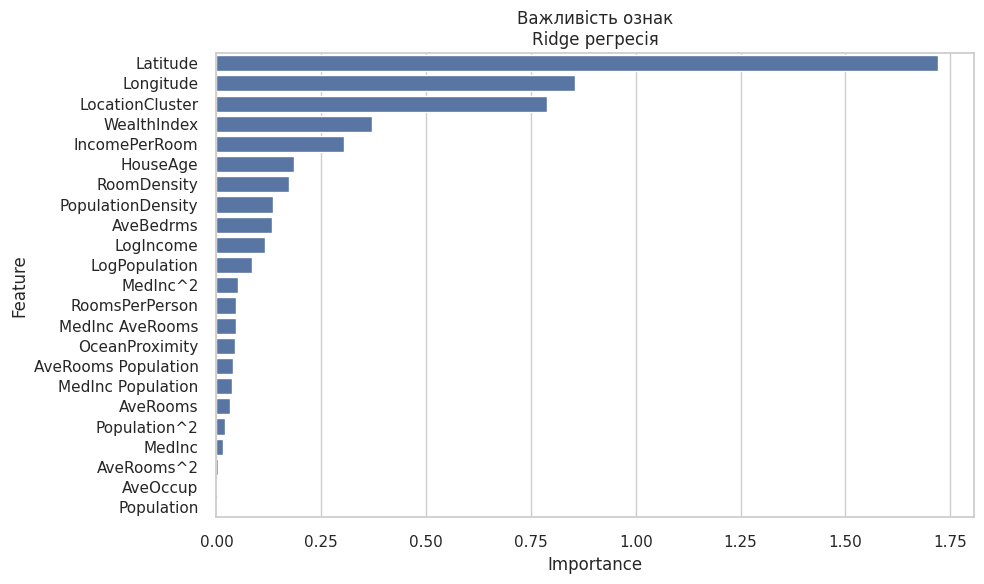

In [13]:
# Make sure we use clean data for Ridge regression
X_train_clean = X_train_scaled.dropna()
y_train_clean = y_train[X_train_clean.index]

X_test_clean = X_test_scaled.dropna()
y_test_clean = y_test[X_test_clean.index]

# Ridge регресія з підбором гіперпараметрів
param_grid = {"alpha": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
ridge_cv = GridSearchCV(Ridge(), param_grid, cv=5)
ridge_cv.fit(X_train_clean, y_train_clean)

print("\nНайкращі параметри Ridge:", ridge_cv.best_params_)
print("Найкращий показник Ridge:", ridge_cv.best_score_)

# Оцінка найкращої Ridge моделі
best_ridge = ridge_cv.best_estimator_
y_pred_ridge, residuals_ridge, ridge_metrics = evaluate_model(
    best_ridge, X_train_clean, X_test_clean, 
    y_train_clean, y_test_clean, "Ridge регресія"
)

# Візуалізація важливості ознак для Ridge регресії
ridge_importance = plot_feature_importance(best_ridge, X_train_clean.columns, "Ridge регресія")

## 9. Висновки

In [14]:
def make_conclusions(lr_metrics, ridge_metrics, feature_importance):
    """Формування висновків про якість моделей та важливість ознак"""
    print("\nВИСНОВКИ:")
    print("1. Порівняння моделей:")
    print(
        f"   Лінійна регресія: R2={lr_metrics['r2']:.3f}, RMSE={lr_metrics['rmse']:.3f}"
    )
    print(
        f"   Ridge регресія: R2={ridge_metrics['r2']:.3f}, RMSE={ridge_metrics['rmse']:.3f}"
    )

    print("\n2. Найважливіші фактори впливу на ціну:")
    for feature, importance in feature_importance.items():
        print(f"   - {feature}: {importance:.3f}")

    print("\n3. Рекомендації:")
    if ridge_metrics["r2"] > lr_metrics["r2"]:
        print(
            "   - Ridge регресія показує кращі результати, рекомендується використовувати її"
        )
    else:
        print("   - Проста лінійна регресія достатня для даної задачі")



feature_importance = dict(zip(X_train_scaled.columns, np.abs(lr_model.coef_)))
make_conclusions(lr_metrics, ridge_metrics, feature_importance)


ВИСНОВКИ:
1. Порівняння моделей:
   Лінійна регресія: R2=0.630, RMSE=0.679
   Ridge регресія: R2=0.630, RMSE=0.678

2. Найважливіші фактори впливу на ціну:
   - MedInc: 0.015
   - AveRooms: 0.035
   - Population: 0.001
   - MedInc^2: 0.052
   - MedInc AveRooms: 0.047
   - MedInc Population: 0.039
   - AveRooms^2: 0.005
   - AveRooms Population: 0.041
   - Population^2: 0.019
   - HouseAge: 0.750
   - AveBedrms: 0.132
   - AveOccup: 0.003
   - Latitude: 2.206
   - Longitude: 0.866
   - RoomsPerPerson: 0.046
   - PopulationDensity: 0.133
   - LogPopulation: 0.086
   - LogIncome: 0.122
   - LocationCluster: 1.241
   - IncomePerRoom: 0.296
   - RoomDensity: 0.173
   - OceanProximity: 0.609
   - WealthIndex: 0.368

3. Рекомендації:
   - Проста лінійна регресія достатня для даної задачі
